In [1]:
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [3]:
mnist = input_data.read_data_sets('MNIST_data/', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [5]:
X = tf.placeholder(tf.float32, shape=[None, 784], name="X")
D_W1 = tf.Variable(xavier_init([784, 128]), name="D_W1")
D_b1 = tf.Variable(tf.zeros(shape=[128]), name="D_b1")
D_W2 = tf.Variable(xavier_init([128, 1]), name="D_W2")
D_b2 = tf.Variable(tf.zeros(shape=[1]), name="D_b2")
D_params = [D_W1, D_b1, D_W2, D_b2]

In [6]:
# Z is noised input
# G(z) => generated new x
Z = tf.placeholder(tf.float32, shape=[None, 100], name="Z")
G_W1 = tf.Variable(xavier_init([100, 128]), name="G_W1")
G_b1 = tf.Variable(tf.zeros(shape=[128]), name="G_b1")
G_W2 = tf.Variable(xavier_init([128, 784]), name="G_W2")
G_b2 = tf.Variable(tf.zeros(shape=[784]), name="G_b2")
G_params = [G_W1, G_b1, G_W2, G_b2]

In [7]:
def discriminator(x, reuse=False):
    # 여기서는 variable 을 따로 생성해서 박아주기 때문에 reuse 가 의미가 없음.
    # reuse 가 있는 경우는 get_variable 과 같이 쓰일때. get_variable 을 사용하면,
    # 처음에는 변수를 생성해주고, reuse 가 on 된 다음부터는 해당 scope 의 variable 을 리턴한다.
    # 또한, 동일한 namespace 의 variable 을 중복 생성할 수 없다.
    # 이 코드와 같이 해도 되지만 캡슐화와 구조화를 위해서 이러한 기능을 지원한다고 함.
    # https://www.tensorflow.org/programmers_guide/variable_scope
    with tf.variable_scope("discriminator") as scope:
#         if reuse:
#             scope.reuse_variables()
        D_a1 = tf.matmul(x, D_W1) + D_b1
        D_h1 = tf.nn.relu(D_a1)
        # what is logit?
        # logit is inverse function of sigmoid function
        # therefore, D_logit = logit(D_prob).
        # 즉, sigmoid 함수에 들어가는 값이 logit 이라고 할 수 있음.
        D_logit = tf.matmul(D_h1, D_W2) + D_b2
        D_prob = tf.nn.sigmoid(D_logit)
    
    return D_prob, D_logit

In [8]:
def generator(z):
    with tf.variable_scope("generator"):
        G_a1 = tf.matmul(z, G_W1) + G_b1
        G_h1 = tf.nn.relu(G_a1)
        # what is differ between logit <> log_prob ?
        # 이것도 걍 로짓이 맞는거 같은데? logit_prob 의 약자일것 같음.
        G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
        G_prob = tf.nn.sigmoid(G_log_prob)
    
    return G_prob

In [9]:
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

In [10]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

## Question

* 왜 D_loss_fake != 0 인가?  
* CE 인데 정답 레이블이 전부 0이면 loss 가 0이 되어야 하는 게 아닌가?

### Answer

* 내가 CE 를 잘못 이해하고 있었음.
* CE 의 식은 C = -1/n \sum [yln(a) + (1-y)ln(1-a)]
* 즉, 정답레이블이 1이든 0이든 정답과 예측값과의 차이를 계산하여 로스로 사용함.
    * 이 값은 ln(x) 의 [0,1] 구간을 사용하여 계산하므로, 정답에서 크게 멀어질수록 로스값이 기하급수적으로 증가한다.
* one-hot vector 에 CE 를 적용할때랑은 다른가...?
    * pset 1 다시 보면서 체크해보자.

In [11]:
G_sample = generator(Z)
D_real, D_logit_real = discriminator(X)
D_fake, D_logit_fake = discriminator(G_sample, reuse=True)

# V1. paper-based learning (다른 코드를 보면 logit 을 이용해서 CE로 계산을 함. 이게 더 성능이 잘 나오나봄)
# http://bamos.github.io/2016/08/09/deep-completion/ 참고
# 아래 함수자체가 CE기 때문에, 알고리즘은 동일하고, 다만 연산속도가 logits 으로 계산하는게 더 빠른가보다.

# maximize x => minimize -x
#D_loss = -tf.reduce_mean(tf.log(D_real) + tf.log(1-D_fake))
#G_loss = -tf.reduce_mean(tf.log(D_fake))

# V2.
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))

D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=D_params)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=G_params)

In [12]:
batch_size = 64
Z_dim = 100
N = mnist.train.num_examples

[      0] D_loss: 0.0152 / G_loss: 7.2099


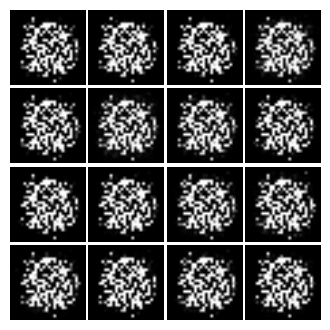

[      1] D_loss: 0.0387 / G_loss: 7.8732


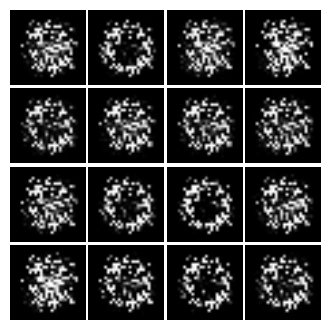

[      2] D_loss: 0.0588 / G_loss: 4.2665


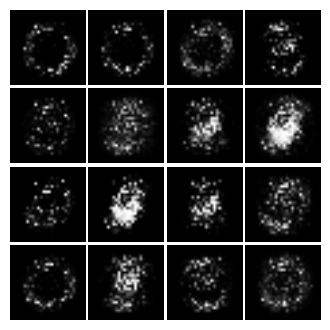

[      3] D_loss: 0.1360 / G_loss: 4.6854


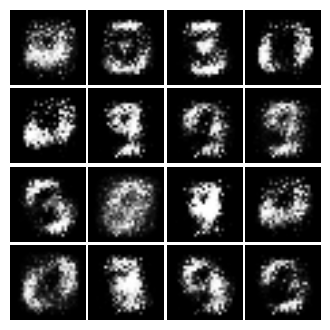

[      4] D_loss: 0.0476 / G_loss: 5.5984


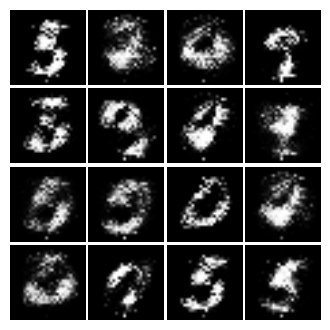

[      5] D_loss: 0.1260 / G_loss: 5.6143


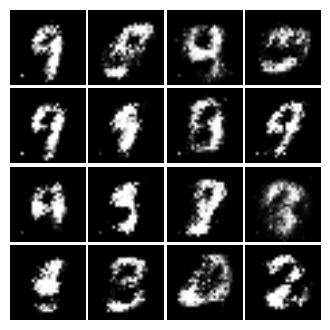

[      6] D_loss: 0.3062 / G_loss: 4.6742


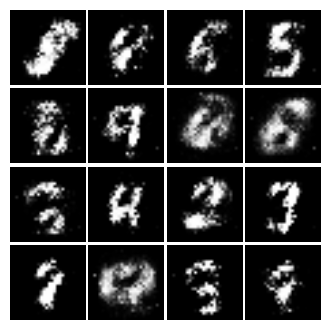

[      7] D_loss: 0.4215 / G_loss: 3.6730


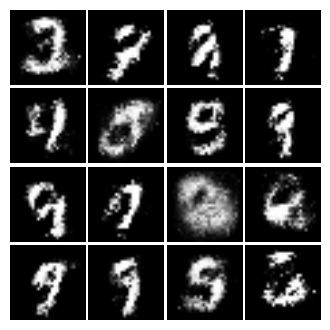

[      8] D_loss: 0.5081 / G_loss: 3.6424


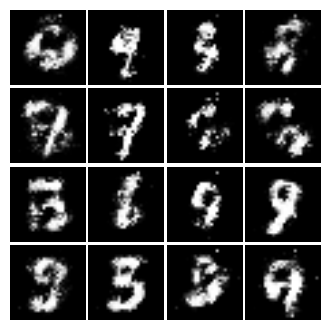

[      9] D_loss: 0.5172 / G_loss: 3.2871


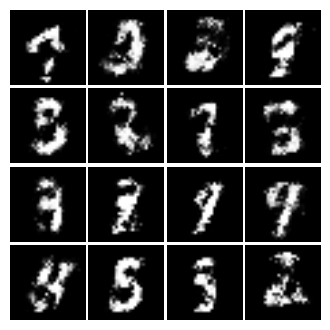

[     10] D_loss: 0.4800 / G_loss: 2.9761


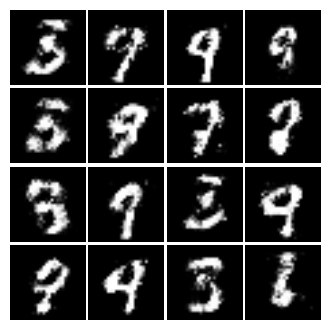

[     11] D_loss: 0.7552 / G_loss: 3.0983


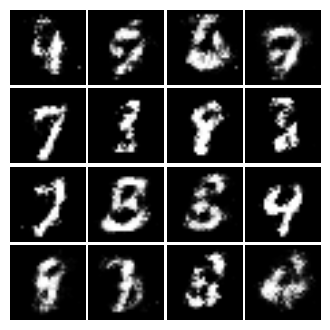

[     12] D_loss: 0.6641 / G_loss: 3.1472


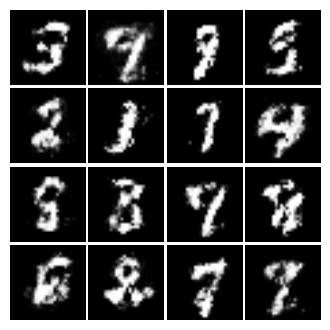

[     13] D_loss: 0.6013 / G_loss: 2.6197


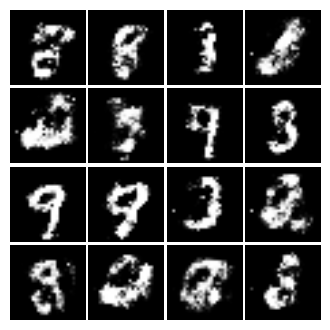

[     14] D_loss: 0.4888 / G_loss: 2.6004


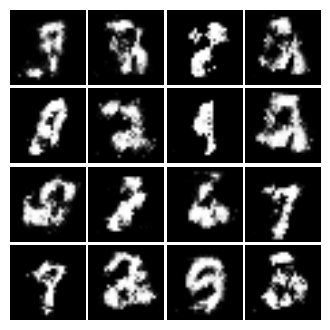

[     15] D_loss: 0.6203 / G_loss: 2.5691


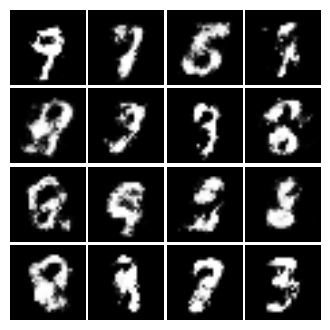

[     16] D_loss: 0.6758 / G_loss: 2.0404


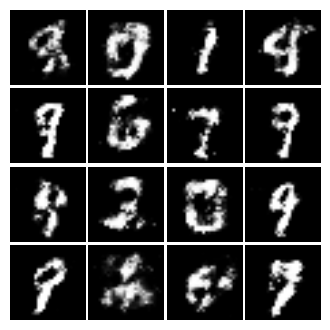

[     17] D_loss: 0.7015 / G_loss: 2.3150


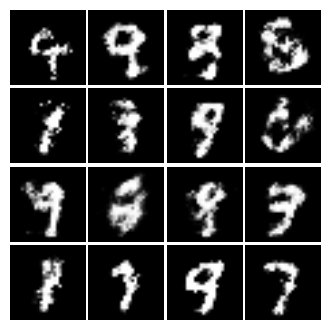

[     18] D_loss: 0.8921 / G_loss: 2.3992


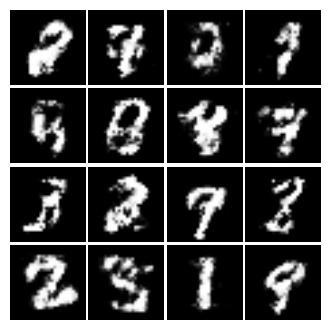

[     19] D_loss: 0.5746 / G_loss: 2.8048


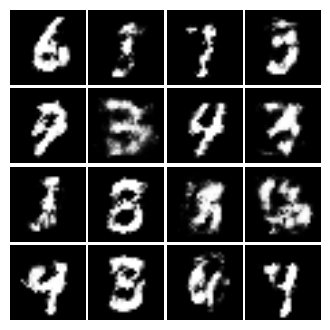

[     20] D_loss: 0.7746 / G_loss: 2.0547


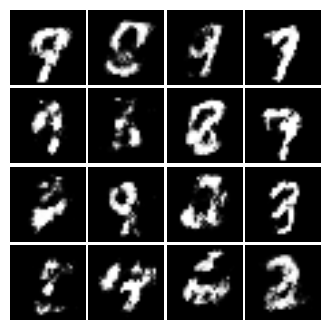

[     21] D_loss: 0.7331 / G_loss: 2.3412


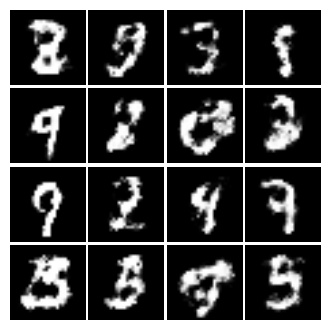

[     22] D_loss: 0.8320 / G_loss: 1.9131


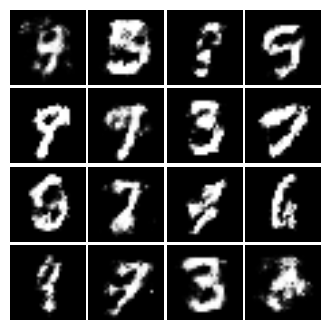

[     23] D_loss: 0.7670 / G_loss: 2.0906


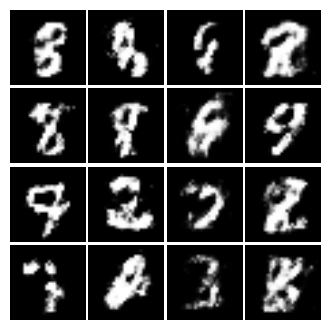

[     24] D_loss: 0.6350 / G_loss: 2.1782


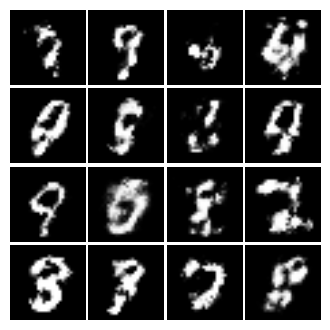

[     25] D_loss: 0.8772 / G_loss: 1.8722


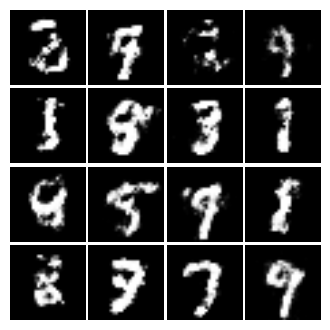

[     26] D_loss: 0.6962 / G_loss: 2.1201


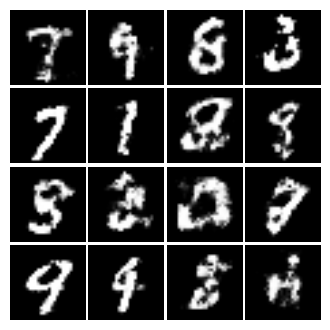

[     27] D_loss: 0.5708 / G_loss: 2.0740


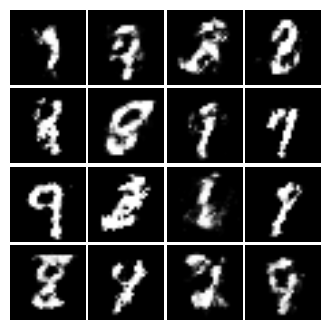

[     28] D_loss: 0.5745 / G_loss: 2.0917


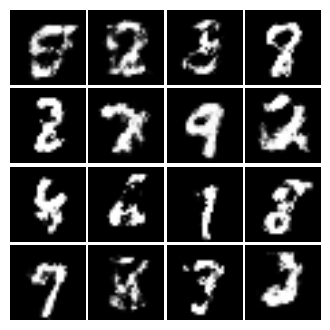

[     29] D_loss: 0.7519 / G_loss: 2.3074


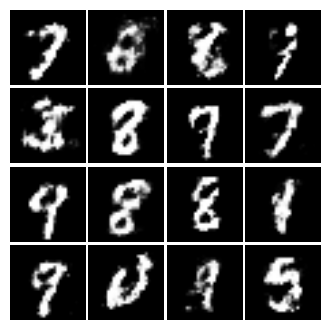

[     30] D_loss: 0.6307 / G_loss: 2.2149


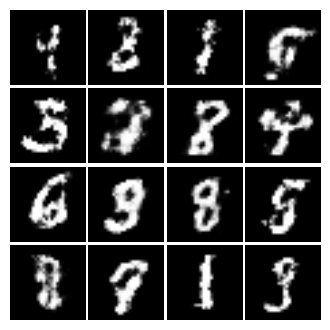

[     31] D_loss: 0.8048 / G_loss: 2.0328


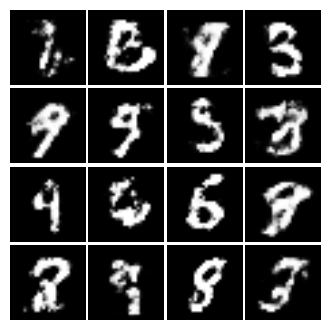

[     32] D_loss: 0.6136 / G_loss: 2.3077


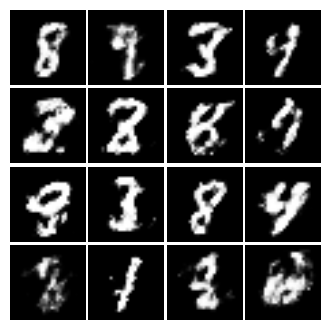

[     33] D_loss: 0.6722 / G_loss: 2.5090


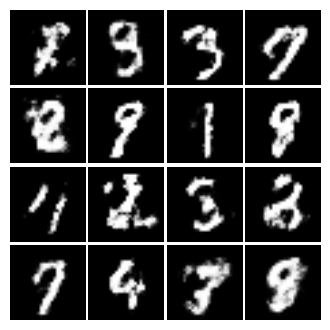

[     34] D_loss: 0.7175 / G_loss: 2.5147


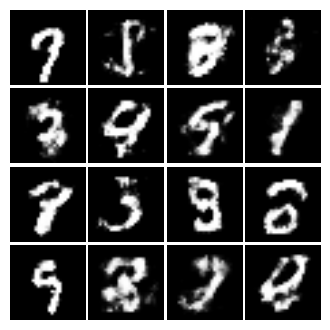

[     35] D_loss: 0.7905 / G_loss: 2.1101


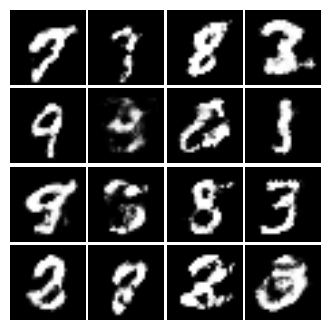

[     36] D_loss: 0.7505 / G_loss: 1.8628


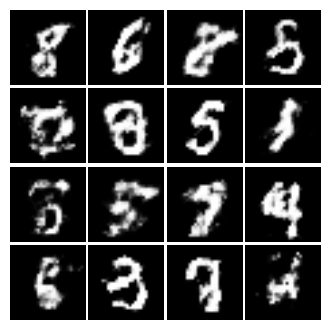

[     37] D_loss: 0.7109 / G_loss: 2.1446


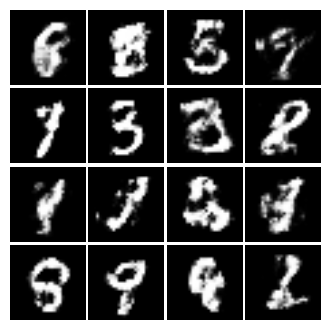

[     38] D_loss: 0.7760 / G_loss: 2.4771


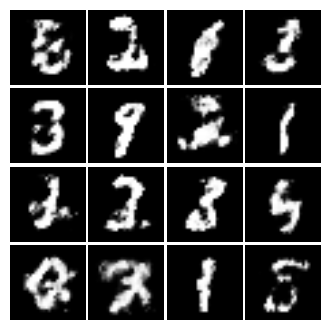

[     39] D_loss: 0.5732 / G_loss: 2.2231


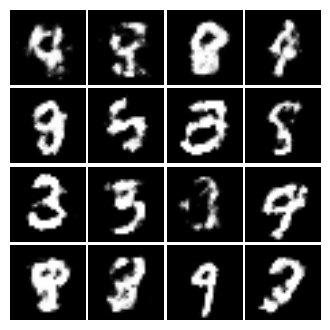

In [14]:
sess = tf.Session()
# sess.run(tf.initialize_all_variables())
sess.run(tf.global_variables_initializer())

tf.reset_default_graph()
writer = tf.summary.FileWriter("./tmp2/", sess.graph)

idx = 0

for it in range(40):
    # _ 는 원래 Y 임.
    for _ in range(N // batch_size):
        X_batch, _ = mnist.train.next_batch(batch_size)

        _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_batch, Z: sample_Z(batch_size, Z_dim)})
        _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: sample_Z(batch_size, Z_dim)})
    
    print("[{:7d}] D_loss: {:.4f} / G_loss: {:.4f}".format(it, D_loss_curr, G_loss_curr))

    samples = sess.run(G_sample, feed_dict={Z: sample_Z(16, Z_dim)})

    fig = plot(samples)
    plt.show()
#         plt.savefig('out/{:0>4d}.png'.format(idx), bbox_inches='tight')
#         idx += 1
#         plt.close(fig)
